# Modelling shot conversion rates with beta distribution, and performing empirical Bayes update.

This is like a zeroth iteration of a finishing skill estimation. We won't be using the advanced stats (xG) here. We simply take a look at shot conversion rates - non-penalty goals/non-penalty xG. As it turns out, quantities like these can be modeled by a "beta" distribution (conjugate to binomial processes - shot is either converted or not). As I said - extremely simplistic view of goalscoring. We start with a "prior" distribution that is created empirically. That is, we use the data of the entire population to create our prior beta distribution model. Once we have our priors, we update the model for each player using their shots and npGs. Start by loading the necessary libraries. We will using scipy.stats for the models.

In [1]:
%load_ext autoreload
%autoreload 2
from scipy.stats import beta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import matplotlib.cm as cm

Create the shot conversion rate column. We will only retain players who have atleast 10 shots and scored atleast once. We will use the entire population's conversion rate data to create out prior beta model.

In [2]:
df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 10)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
print(bf[0], bf[1])

3.259724251792543 30.304150963264032


Once we have our prior model, we can update the "posterior" models for each player using their own data. For beta distributions, the update can be expressed in an analytic closed form as done below. 'Eb_Conv' is the empirical Bayes estimation of a player's conversion rate. 

In [3]:
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])
df.sort_values(by='Shots', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Player,90s,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv
0,Anthony Elanga (2002),4.5,2.0,10.0,0.0,1.3,2.0,2002.0,19.0,0.2,0.120736
1,Keita Endo (1997),5.4,1.0,10.0,0.0,1.2,1.0,1997.0,24.0,0.1,0.097781
2,Jutglà (1999),3.3,1.0,10.0,0.0,1.6,1.0,1999.0,22.0,0.1,0.097781
3,Cesar Falletti (1992),3.6,1.0,10.0,0.0,1.4,1.0,1992.0,29.0,0.1,0.097781
4,Christian Gebauer (1993),7.6,1.0,10.0,0.0,2.0,1.0,1993.0,28.0,0.1,0.097781


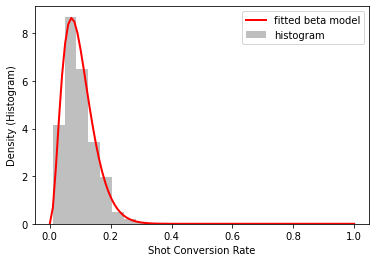

In [4]:
fig,ax = plt.subplots()
ax.hist(df['Conv'], density = True, label = 'histogram',color='grey',alpha=0.5)
ax.plot(np.linspace(0,1,100), beta.pdf(np.linspace(0,1,100),bf[0],bf[1]),
        label = 'fitted beta model',color='r',lw=2)
ax.set_xlabel('Shot Conversion Rate');
ax.set_ylabel('Density (Histogram)');
ax.legend();

The above plot shows the histogram of the entire population's conversion rates and the fitted prior beta distribution. The following plot shows "shrinkage". Players with small number of shots could have absurdly high/low conversion rates due to "good"/"bad" luck (or fortuituous/unfortunate finishing streak, as you wish to call it). Their values get shrunk towards the empirical Bayes estimated mean, which is the horizontal line. Players with enough volume of shots have their actual conversion rates pretty similar to the estimated conversion rates and don't show significant shrinkage - they lie on the diagonal x=y line.

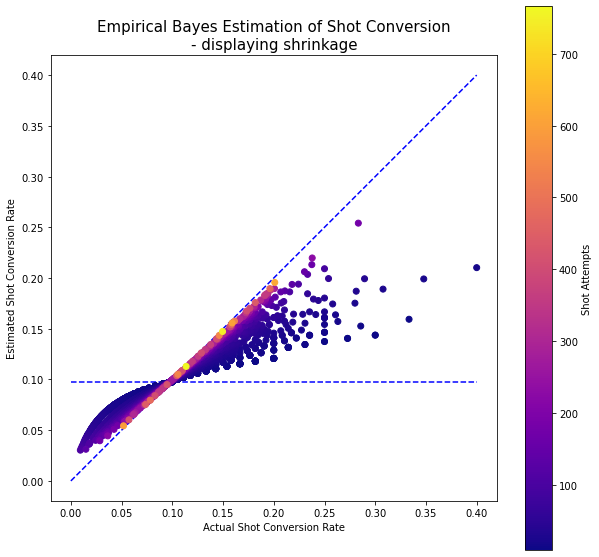

In [5]:
fig,ax  = plt.subplots(figsize = (10,10))
im = ax.scatter(df['Conv'], df['Eb_Conv'],
           c=df['Shots'],cmap=cm.plasma,zorder=10)
ax.plot(np.linspace(0,0.4,10), np.linspace(0,0.4,10),ls='--',color='b')
ax.plot(np.linspace(0,0.4,10), np.ones(10)*bf[0]/(bf[0] + bf[1]),ls='--',color='b')
ax.set_aspect('equal')
ax.set_xlabel('Actual Shot Conversion Rate');
ax.set_ylabel('Estimated Shot Conversion Rate');
fig.colorbar(im, ax=ax).set_label('Shot Attempts');
ax.set_title('Empirical Bayes Estimation of Shot Conversion'+'\n'+
             '- displaying shrinkage', fontsize = 15);